In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("D:\Smart_Agriculture\greenhouse_lettuce_timeseries.csv", parse_dates=["timestamp"])

In [3]:
# --- Summary ---
print(df.describe(include="all").T)

                        count                 mean                  min  \
timestamp                4680  2025-04-08 17:30:00  2025-01-01 06:00:00   
temperature_C          4680.0            21.500912                16.43   
humidity_env_frac      4680.0             0.649983                0.577   
soil_moisture_frac     4680.0              0.71666                0.605   
soil_moisture_plus_1h  4679.0             0.716645                0.605   
soil_moisture_plus_3h  4677.0             0.716621                0.605   
soil_moisture_plus_6h  4674.0             0.716589                0.605   
hour                   4680.0                 11.5                  0.0   
dayofweek              4680.0             3.008974                  0.0   
sin_hour               4680.0                  0.0                 -1.0   
cos_hour               4680.0                 -0.0                 -1.0   

                                       25%                  50%  \
timestamp              2025-02-1

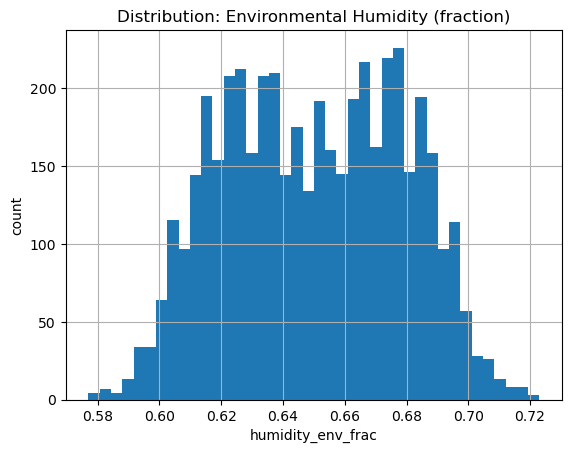

In [4]:
# --- Hist: humidity_env_frac ---
plt.figure()
df["humidity_env_frac"].hist(bins=40)
plt.title("Distribution: Environmental Humidity (fraction)")
plt.xlabel("humidity_env_frac"); plt.ylabel("count")
plt.show()

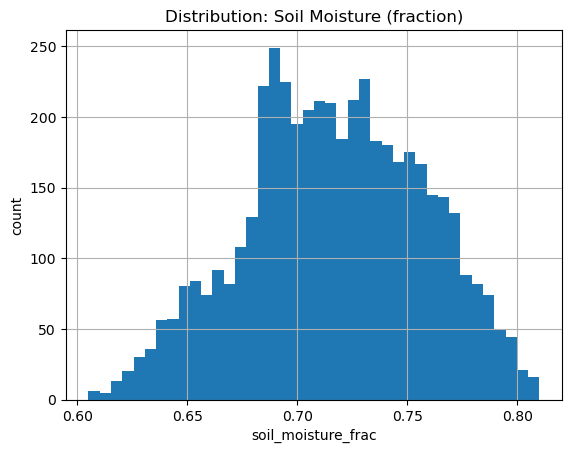

In [5]:
# --- Hist: soil_moisture_frac ---
plt.figure()
df["soil_moisture_frac"].hist(bins=40)
plt.title("Distribution: Soil Moisture (fraction)")
plt.xlabel("soil_moisture_frac"); plt.ylabel("count")
plt.show()

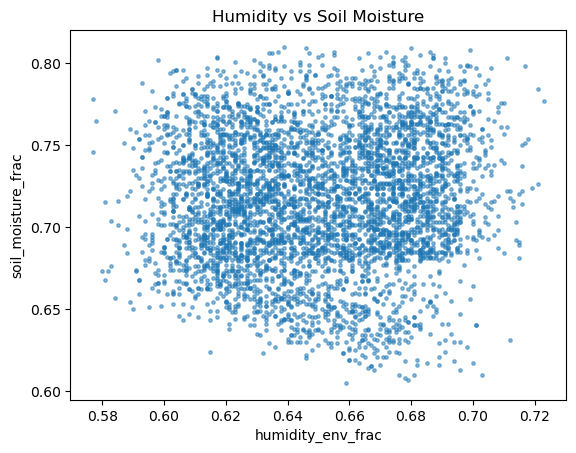

In [6]:
# --- Scatter: humidity vs soil moisture ---
plt.figure()
plt.scatter(df["humidity_env_frac"], df["soil_moisture_frac"], s=6, alpha=0.5)
plt.title("Humidity vs Soil Moisture")
plt.xlabel("humidity_env_frac"); plt.ylabel("soil_moisture_frac")
plt.show()

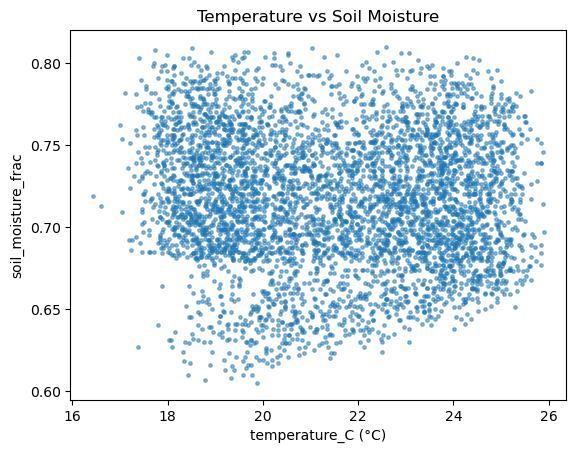

In [7]:
# --- Scatter: temperature vs soil moisture ---
plt.figure()
plt.scatter(df["temperature_C"], df["soil_moisture_frac"], s=6, alpha=0.5)
plt.title("Temperature vs Soil Moisture")
plt.xlabel("temperature_C (°C)"); plt.ylabel("soil_moisture_frac")
plt.show()

In [8]:
# --- Correlations ---
r_h_sm, p_h_sm = pearsonr(df["humidity_env_frac"], df["soil_moisture_frac"])
r_t_sm, p_t_sm = pearsonr(df["temperature_C"], df["soil_moisture_frac"])
print({"humidity↔soil": (r_h_sm, p_h_sm), "temp↔soil": (r_t_sm, p_t_sm)})

{'humidity↔soil': (0.059200976025141974, 5.068569885325677e-05), 'temp↔soil': (-0.06319558986801128, 1.515568939742048e-05)}


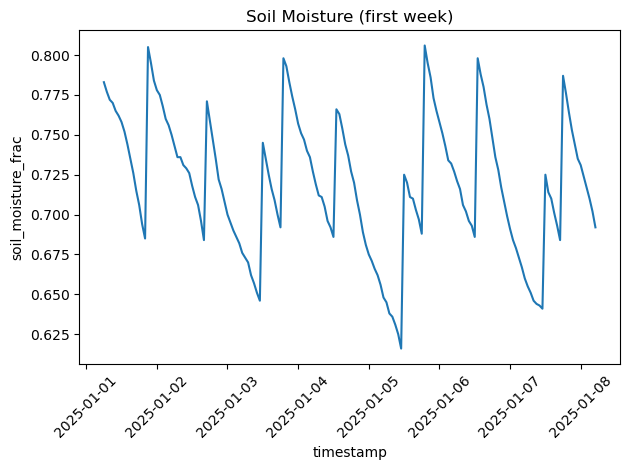

In [9]:
# --- Optional: time-series week 1 ---
sample = df.iloc[:24*7]
plt.figure()
plt.plot(sample["timestamp"], sample["soil_moisture_frac"])
plt.title("Soil Moisture (first week)")
plt.xlabel("timestamp"); plt.ylabel("soil_moisture_frac")
plt.xticks(rotation=45); plt.tight_layout()
plt.show()

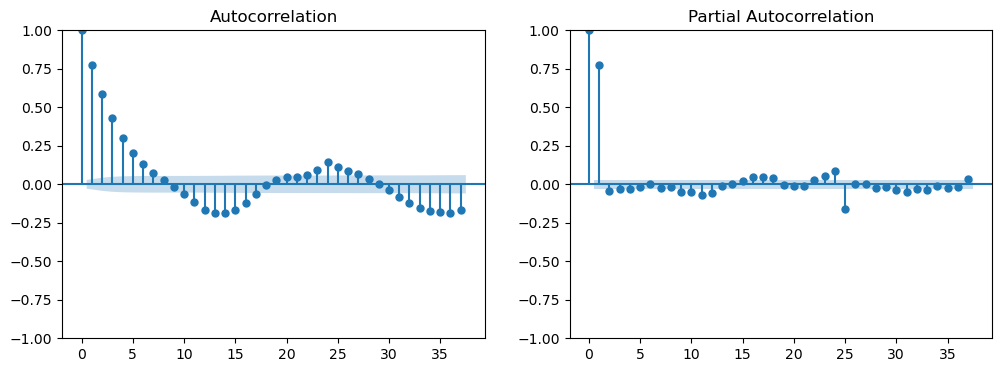

In [10]:
# --- ACF & PACF ---
df['sm_lag1'] = df['soil_moisture_frac'].shift(1)
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(df['soil_moisture_frac'].dropna(), ax=ax[0])
plot_pacf(df['soil_moisture_frac'].dropna(), ax=ax[1])
plt.show()

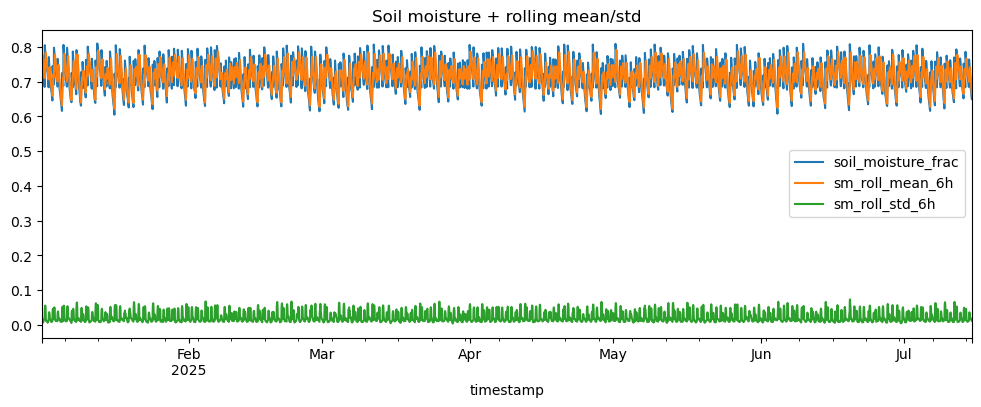

In [11]:
# --- Rolling statistics ---
df2 = df.set_index("timestamp")

df2["sm_roll_mean_6h"] = df2["soil_moisture_frac"].rolling("6h").mean()
df2["sm_roll_std_6h"]  = df2["soil_moisture_frac"].rolling("6h").std()

df2[["soil_moisture_frac","sm_roll_mean_6h","sm_roll_std_6h"]].plot(figsize=(12,4))
plt.title("Soil moisture + rolling mean/std")
plt.show()

#### Event detection 

In [12]:
df["delta_sm"] = df["soil_moisture_frac"].diff()

# Tưới khi tăng > 0.03
df["irrigation"] = df["delta_sm"] > 0.03

df["irrigation"].value_counts()

irrigation
False    4375
True      305
Name: count, dtype: int64

In [13]:
# --- Event detection --- sau tưới
events = df[df["irrigation"] == True][["timestamp","soil_moisture_frac"]]
events.head()

,timestamp,soil_moisture_frac
15,2025-01-01 21:00:00,0.805
35,2025-01-02 17:00:00,0.771
54,2025-01-03 12:00:00,0.745
61,2025-01-03 19:00:00,0.798
79,2025-01-04 13:00:00,0.766


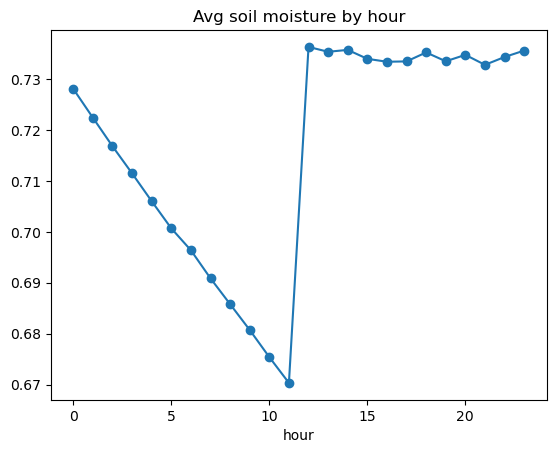

In [14]:
# Avarage theo giờ 
df["hour"] = df["timestamp"].dt.hour
df.groupby("hour")["soil_moisture_frac"].mean().plot(kind="line", marker="o")
plt.title("Avg soil moisture by hour")
plt.show()

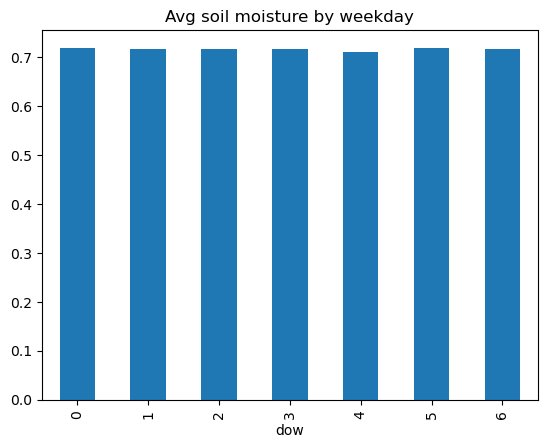

In [15]:
#### Weekday insight 
df["dow"] = df["timestamp"].dt.dayofweek
df.groupby("dow")["soil_moisture_frac"].mean().plot(kind="bar")
plt.title("Avg soil moisture by weekday")
plt.show()

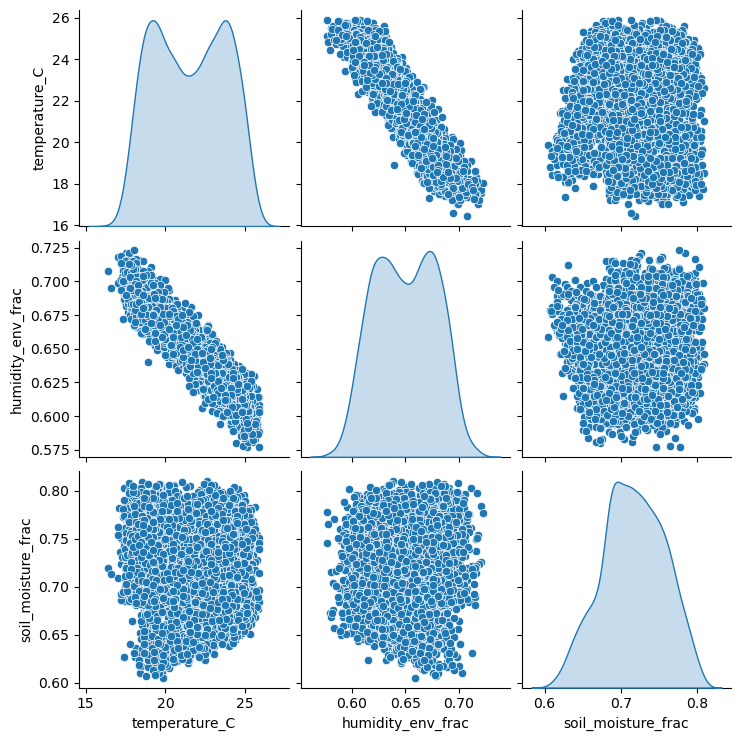

In [16]:
import seaborn as sns

sns.pairplot(df[["temperature_C","humidity_env_frac","soil_moisture_frac"]], diag_kind="kde")
plt.show()

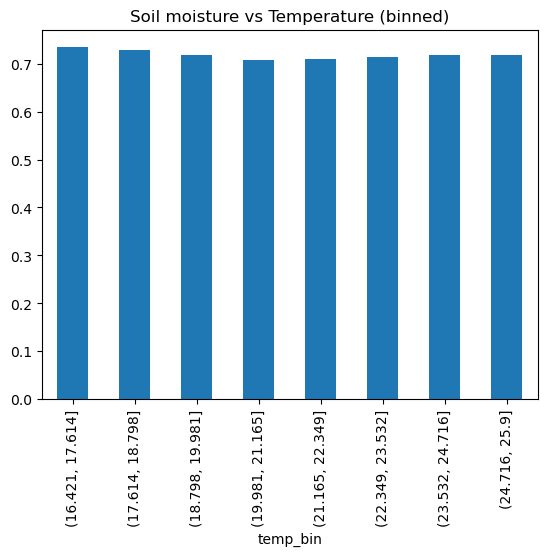

In [17]:
# Binned temperature vs soil moisture
df["temp_bin"] = pd.cut(df["temperature_C"], bins=8)
df.groupby("temp_bin")["soil_moisture_frac"].mean().plot(kind="bar")
plt.title("Soil moisture vs Temperature (binned)")
plt.show()

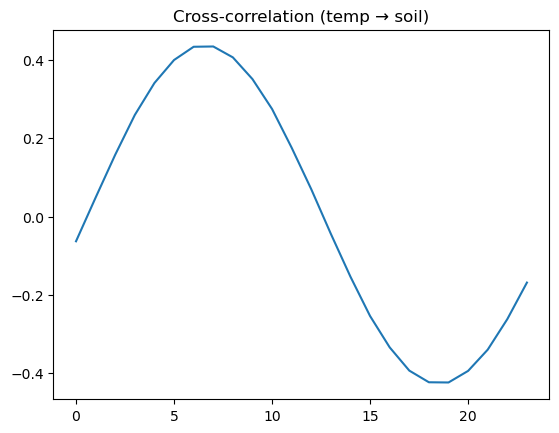

In [18]:
# cross-correlation (XCF)

from statsmodels.tsa.stattools import ccf

x = df["temperature_C"]
y = df["soil_moisture_frac"]

cc = ccf(x, y)[:24]  # 24h lag
plt.plot(cc)
plt.title("Cross-correlation (temp → soil)")
plt.show()

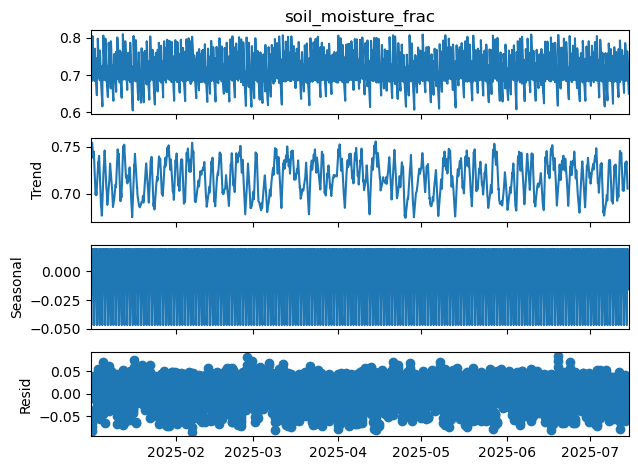

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df2["soil_moisture_frac"].resample("1H").mean(), model="additive", period=24)
res.plot()
plt.show()


#### Thêm VPD + feature engineering

In [20]:
# Tính VPD bằng Tetens
# T (°C), RH (fraction 0-1)
T = df["temperature_C"]
RH = df["humidity_env_frac"]

es = 0.6108 * np.exp((17.27 * T) / (T + 237.3))   # kPa
ea = es * RH
df["VPD_kPa"] = es - ea

In [21]:
# Lag & rolling
df["sm_roll_mean_6h"] = df2["soil_moisture_frac"].rolling("6h").mean().shift(1)
df["sm_roll_std_6h"]  = df2["soil_moisture_frac"].rolling("6h").std().shift(1)


### EDA cho VPD

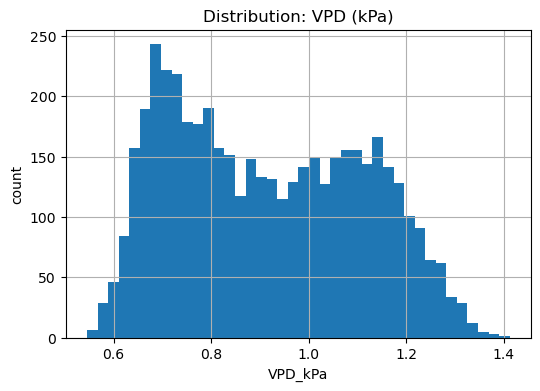

In [22]:
plt.figure(figsize=(6,4))
df["VPD_kPa"].hist(bins=40)
plt.title("Distribution: VPD (kPa)")
plt.xlabel("VPD_kPa"); plt.ylabel("count")
plt.show()

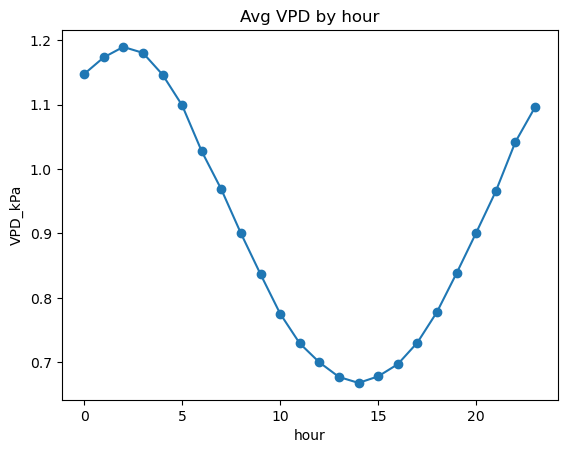

In [23]:
# VPD theo giờ trong ngày (để thấy pattern ngày–đêm)
df["hour"] = df["timestamp"].dt.hour
df.groupby("hour")["VPD_kPa"].mean().plot(kind="line", marker="o")
plt.title("Avg VPD by hour")
plt.ylabel("VPD_kPa")
plt.show()


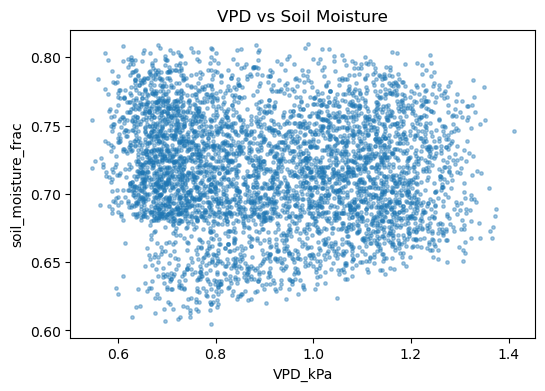

In [24]:
# Scatter: VPD ↔ Soil Moisture
plt.figure(figsize=(6,4))
plt.scatter(df["VPD_kPa"], df["soil_moisture_frac"], s=6, alpha=0.4)
plt.xlabel("VPD_kPa"); plt.ylabel("soil_moisture_frac")
plt.title("VPD vs Soil Moisture")
plt.show()


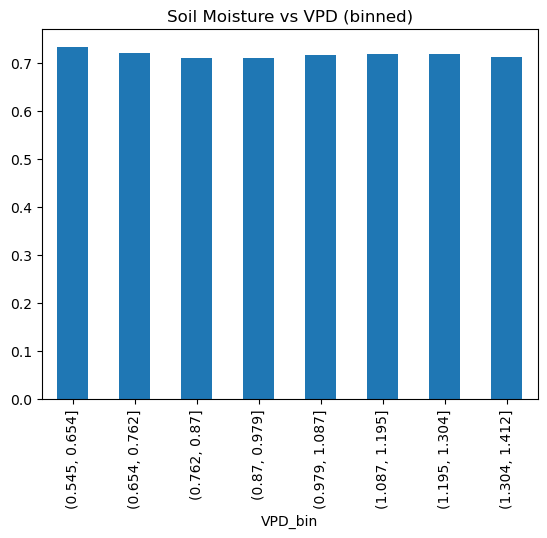

In [25]:
#Binned VPD vs Soil Moisture
df["VPD_bin"] = pd.cut(df["VPD_kPa"], bins=8)
df.groupby("VPD_bin")["soil_moisture_frac"].mean().plot(kind="bar")
plt.title("Soil Moisture vs VPD (binned)")
plt.show()


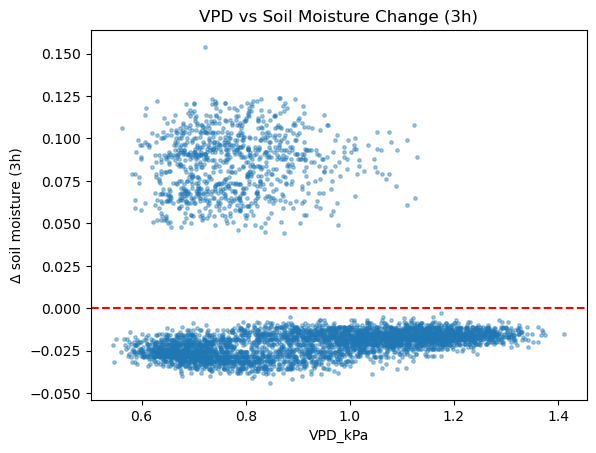

In [26]:
#Scatter VPD ↔ delta soil moisture (3h)
df["delta_sm_3h"] = df["soil_moisture_plus_3h"] - df["soil_moisture_frac"]

plt.scatter(df["VPD_kPa"], df["delta_sm_3h"], s=6, alpha=0.4)
plt.xlabel("VPD_kPa"); plt.ylabel("Δ soil moisture (3h)")
plt.title("VPD vs Soil Moisture Change (3h)")
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [27]:
#Correlation VPD ↔ Soil Moisture
from scipy.stats import pearsonr
r, p = pearsonr(df["VPD_kPa"], df["soil_moisture_frac"])
print("corr(VPD, soil) =", r, "p=", p)

corr(VPD, soil) = -0.052478035489238545 p= 0.00032869720781581336


In [28]:
# Tạo target soil_moisture_plus_3h_adj
# Chọn “tâm” VPD và hệ số ảnh hưởng
vpd_center = df["VPD_kPa"].median()   # khoảng ~0.9–1.0 kPa trong data của bạn
factor = 0.02                         # 0.02 = mỗi 1 kPa lệch thì điều chỉnh ~0.02 (2%)

print("VPD median =", vpd_center)

VPD median = 0.8969698894718303


In [29]:
# 2. Tạo target mới: soil_moisture_plus_3h_adj
df["soil_moisture_plus_3h_adj_raw"] = (
    df["soil_moisture_plus_3h"]
    - factor * (df["VPD_kPa"] - vpd_center)
)

In [30]:
# 3. Giới hạn vật lý: không cho lệch quá mạnh so với soil hiện tại
lower_bound = df["soil_moisture_frac"] - 0.04   # tối đa khô thêm ~0.04 trong 3h
upper_bound = df["soil_moisture_frac"] + 0.12   # tối đa ướt hơn ~0.12 sau tưới

df["soil_moisture_plus_3h_adj"] = df["soil_moisture_plus_3h_adj_raw"].clip(
    lower=lower_bound,
    upper=upper_bound
)

In [31]:
# so sánh correlation trước/sau điều chỉnh
from scipy.stats import pearsonr

# Corr cũ (VPD vs soil_moisture_plus_3h gốc)
mask_valid = df["soil_moisture_plus_3h"].notna()
r_old, p_old = pearsonr(df.loc[mask_valid, "VPD_kPa"],
                        df.loc[mask_valid, "soil_moisture_plus_3h"])
print("OLD corr(VPD, soil_3h) =", r_old, "p=", p_old)

# Corr mới (VPD vs soil_moisture_plus_3h_adj)
mask_valid_adj = df["soil_moisture_plus_3h_adj"].notna()
r_new, p_new = pearsonr(df.loc[mask_valid_adj, "VPD_kPa"],
                        df.loc[mask_valid_adj, "soil_moisture_plus_3h_adj"])
print("NEW corr(VPD, soil_3h_adj) =", r_new, "p=", p_new)

OLD corr(VPD, soil_3h) = -0.3371948087219018 p= 1.0186793155004094e-124
NEW corr(VPD, soil_3h_adj) = -0.4177686446987704 p= 5.421756072461505e-197


In [32]:
cols_view = [
    "timestamp",
    "soil_moisture_frac",
    "VPD_kPa",
    "soil_moisture_plus_3h",
    "soil_moisture_plus_3h_adj"
]

print(df[cols_view].head(15))

             timestamp  soil_moisture_frac   VPD_kPa  soil_moisture_plus_3h  \
0  2025-01-01 06:00:00               0.783  0.930555                  0.770   
1  2025-01-01 07:00:00               0.777  0.957124                  0.765   
2  2025-01-01 08:00:00               0.772  0.877026                  0.762   
3  2025-01-01 09:00:00               0.770  0.801832                  0.758   
4  2025-01-01 10:00:00               0.765  0.691274                  0.752   
5  2025-01-01 11:00:00               0.762  0.759918                  0.744   
6  2025-01-01 12:00:00               0.758  0.687872                  0.735   
7  2025-01-01 13:00:00               0.752  0.704916                  0.726   
8  2025-01-01 14:00:00               0.744  0.658028                  0.715   
9  2025-01-01 15:00:00               0.735  0.692238                  0.706   
10 2025-01-01 16:00:00               0.726  0.689139                  0.694   
11 2025-01-01 17:00:00               0.715  0.768112

>### **Sau khi thêm “ảnh hưởng VPD”, soil_3h trở nên nhạy hơn với VPD.**
* r từ -0.33 → -0.41
* P-value cực nhỏ (p = 1e-197) → significant


### **Build feature set để train model**

In [33]:
# chuẩn hóa soil lag
df["soil_lag1"] = df["soil_moisture_frac"].shift(1)
df["soil_lag3"] = df["soil_moisture_frac"].shift(3)

# Delta
df["delta_sm_1h"] = df["soil_moisture_frac"] - df["soil_lag1"]
df["delta_sm_3h"] = df["soil_moisture_frac"] - df["soil_lag3"]

# Rolling mean/std
df = df.set_index("timestamp")

df["roll_mean_6h"] = df["soil_moisture_frac"].rolling("6h").mean().shift(1)
df["roll_std_6h"]  = df["soil_moisture_frac"].rolling("6h").std().shift(1)

# time features
df["hour"] = df.index.hour
df["dow"] = df.index.dayofweek

df["sin_hour"] = np.sin(2*np.pi*df["hour"]/24)
df["cos_hour"] = np.cos(2*np.pi*df["hour"]/24)


In [34]:
# Irrigation event
df["irrigation"] = (df["delta_sm_1h"] > 0.03).astype(int)

In [35]:
features = [
    "soil_moisture_frac",
    "soil_lag1", "soil_lag3",
    "delta_sm_1h", "delta_sm_3h",
    "temperature_C",
    "humidity_env_frac",
    "VPD_kPa",
    "irrigation",
    "hour", "sin_hour", "cos_hour",
    "dow",
    "roll_mean_6h", "roll_std_6h"
]

# Prepare dataset for modeling
df_model = df.dropna(subset=features + ["soil_moisture_plus_3h_adj"])

X = df_model[features]
y = df_model["soil_moisture_plus_3h_adj"]

print("Dataset shape:", X.shape)

Dataset shape: (4674, 15)


In [36]:
# train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False   # giữ tính time-series
)

print(X_train.shape, X_test.shape)

(3739, 15) (935, 15)


In [37]:
# Train RandomForest 
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=700,
    max_depth=9,
    min_samples_split=8,
    min_samples_leaf=4,
    max_features = 0.8,
    random_state=42
)

rf.fit(X_train, y_train)

,n_estimators,700
,criterion,'squared_error'
,max_depth,9
,min_samples_split,8
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,0.8
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [38]:
# Evaluate model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.00799105583687895
RMSE: 0.015815963783024967


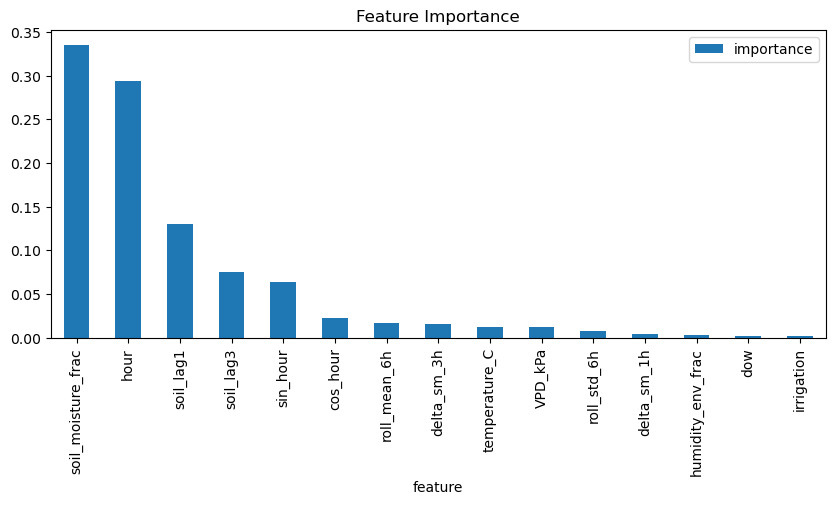

In [39]:
# Feature importance
import pandas as pd
import matplotlib.pyplot as plt

imp = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

imp.plot(kind="bar", x="feature", figsize=(10,4))
plt.title("Feature Importance")
plt.show()


In [40]:
import joblib
joblib.dump(rf, "soil_model_v1.pkl")

['soil_model_v1.pkl']

In [41]:
# Tune theo classification metrics
# quét threshold để phân lớp
from sklearn.metrics import f1_score

best_t = None
best_f1 = -1

for t in np.arange(0.60, 0.75, 0.005):
    y_pred_cls = (pred < t).astype(int)
    y_true_cls = (y_test < t).astype(int)
    
    f1 = f1_score(y_true_cls, y_pred_cls)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best threshold =", best_t)
print("Best F1 =", best_f1)

Best threshold = 0.7500000000000001
Best F1 = 0.960111966410077


In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# threshold
threshold = 0.7500000000000001  # dùng best threshold từ sweep

# 2. convert regression → class
y_pred_cls = (pred < threshold).astype(int)
y_true_cls = (y_test < threshold).astype(int)

# 3. report
print("Confusion Matrix:")
print(confusion_matrix(y_true_cls, y_pred_cls))

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

Confusion Matrix:
[[192  25]
 [ 32 686]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       217
           1       0.96      0.96      0.96       718

    accuracy                           0.94       935
   macro avg       0.91      0.92      0.92       935
weighted avg       0.94      0.94      0.94       935



In [43]:
import joblib
import numpy as np

rf = joblib.load("soil_model_v1.pkl")

class IrrigationController:
    def __init__(self, model, features, cooldown_steps=0):
        self.model = model
        self.features = features
        self.cooldown_steps = 0
        self.cooldown_max = cooldown_steps
        self.last_action = "SKIP"
        self.last_soil = None

    def compute_threshold(self, vpd):
        # rule đơn giản theo VPD – cái này bạn đang dùng khá ổn
        if vpd < 0.75:      # trời ẩm, bốc hơi yếu
            return 0.65
        elif vpd < 1.1:     # bình thường
            return 0.67
        else:               # trời hanh khô/nóng
            return 0.70

    def decide(self, row):
        if isinstance(row, dict):
            vpd = float(row["VPD_kPa"])
            x_vec = np.array([row[f] for f in self.features]).reshape(1, -1)
            soil_now = float(row["soil_moisture_frac"])
        else:
            vpd = float(row["VPD_kPa"])
            x_vec = row[self.features].values.reshape(1, -1)
            soil_now = float(row["soil_moisture_frac"])

        # dự đoán soil 3h tới
        y_pred = float(self.model.predict(x_vec)[0])

        # threshold theo VPD
        thr = self.compute_threshold(vpd)

        # không dùng cooldown phức tạp
        if self.cooldown_steps > 0:
            self.cooldown_steps -= 1
            action = "SKIP"
        else:
            if y_pred < thr:
                action = "IRRIGATE"
                self.cooldown_steps = self.cooldown_max
            else:
                action = "SKIP"

        info = {
            "soil_now": soil_now,
            "pred_soil_3h": y_pred,
            "threshold": thr,
            "VPD_kPa": vpd,
            "cooldown_left": self.cooldown_steps,
        }

        self.last_action = action
        self.last_soil = soil_now
        return action, info


In [44]:
ctrl = IrrigationController(rf, features, cooldown_steps=0)

# Test với dòng dữ liệu mới
row = df_model.iloc[-1]
action, info = ctrl.decide(row)
print(action, info)

IRRIGATE {'soil_now': 0.665, 'pred_soil_3h': 0.6434373165336547, 'threshold': 0.7, 'VPD_kPa': 1.1616095808414575, 'cooldown_left': 0}


#### Test controller

In [45]:
# Prepare test dataframe for controller simulation
from sklearn.model_selection import train_test_split

n_train = len(X_train)
df_test = df_model.iloc[n_train:].copy()   # các dòng tương ứng X_test

In [46]:
# Chạy controller trên df_test
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

actions = []      # 0/1 theo controller
y_true_cls = []   # 0/1 ground truth theo soil_3h_adj
infos = []

threshold_eval = 0.67   # định nghĩa "thiếu nước thật" theo ngưỡng này

for idx, row in df_test.iterrows():
    action, info = ctrl.decide(row)

    actions.append(1 if action == "IRRIGATE" else 0)
    infos.append(info)

    # ground truth class: 1 nếu 3h nữa sẽ khô dưới threshold_eval
    true_class = 1 if row["soil_moisture_plus_3h_adj"] < threshold_eval else 0
    y_true_cls.append(true_class)

actions = np.array(actions)
y_true_cls = np.array(y_true_cls)

print("Confusion Matrix (controller vs ground truth):")
print(confusion_matrix(y_true_cls, actions))

print("\nClassification Report (controller):")
print(classification_report(y_true_cls, actions))


Confusion Matrix (controller vs ground truth):
[[773  36]
 [  8 118]]

Classification Report (controller):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       809
           1       0.77      0.94      0.84       126

    accuracy                           0.95       935
   macro avg       0.88      0.95      0.91       935
weighted avg       0.96      0.95      0.95       935

